<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><img src="https://www.vsn-tv.com/wp-content/uploads/2016/06/Cloud-streaming-platform-vsn.jpg" width="40%"></td>
  </tr>
</table> 
</div>


# From CDN to P2p, a brief dataset analysis : 

Recently, peer-to-peer technology has been welcoming many "shifters" that chose to quit content distribution networks. The reason behind this is the self-scalability of P2P systems provided by the principles of __communal collaboration__ and __resource sharing__ in P2P systems. By building a P2P Content Distribution Network(CDN), peers collaborate to distribute the content of under-provisioned websites and to serve queries for large audiences on behalf of the websites. When designing a P2P CDN, the main challenge is to actually maintain an acceptable level of performance in terms of client-perceived latency and hit ratio while minimizing the incurred overhead. <br><br>
This is not a straightforward endeavor given that the P2P CDN relies on autonomous and dynamic peers rather than a dedicated infrastructure. Indeed, the distribution of duties and content over peers should take into account their interests in order to give them proper incentives to cooperate. Moreover, the P2P-CDN should adapt to increasing numbers of participants and provide robust algorithms under high levels of churn because these issues have a key impact on performance. Finally, the routing of queries should aim peers close in locality and serve content from close-by providers to achieve short latencies.<br><br>
In this notebook, I will be trying to analyze a dataset about peer-to-peer and cdn content retrieval during nine streams. Each row of the dataset corresponds to a user's informations for a given stream : <br><br>
     + The ID of the stream 
     + The Internet Service Providor
     + The type of the browser
     + The status : connected or not
     + P2p retrieval 
     + Cdn retrieval
My two objectives are the following : <br><br>
$\bullet$ Exploring the dataset. <br>
$\bullet$ Giving some recommendations so that to improve the streaming service.<br><br>

My approach will be as following : first, I will start with an exploratory data analysis, including some feature processing which will be useful for some interesting plots. Then, according to those visualizations and some personal reads, I will be trying to give some recommendation as to improve the streaming service. 

## Summary : 

$\bullet$ <a href='#un'>1. Exploratory data analysis.<br><br></a>
$\bullet$ <a href='#deux'>2. Recommendations.<br></a>

<a id='un'></a>
## Exploratory data analysis 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv', sep=',')

In [3]:
data.head()

,#stream,isp,browser,connected,p2p,cdn
0,1,Fro,Iron,True,195910.840977,109025.960619
1,1,Fro,EarthWolf,True,186711.522041,113744.856814
2,1,Arange,Iron,True,189428.293434,115944.246844
3,1,Arange,Iron,True,0.000000,307577.191067
4,1,BTP,EarthWolf,True,207246.640473,107010.608093


__ISP__ : Internet Service Provider<br>
__p2p__ : (Peer-to-peer) : a distributed application architecture that partitions tasks or workloads between peers. Peers are equally privileged, equipotent participants in the application. <br>
__cdn__ : (Content diffusion network)  a geographically distributed network of proxy servers and their data centers. <br>

In [4]:
data.dtypes

#stream        int64
isp           object
browser       object
connected       bool
p2p          float64
cdn          float64
dtype: object

In [5]:
data.isna().sum()

#stream      0
isp          0
browser      0
connected    0
p2p          0
cdn          1
dtype: int64

In [6]:
data[data['cdn'].isnull()]

,#stream,isp,browser,connected,p2p,cdn
534953,9,BTP,EarthWolf,True,6100.582815,NaN


We note that there one single NaN value in the dataset. We will deal with it later during the preprocessing

In [7]:
data.connected.value_counts()

True     485753
False     49201
Name: connected, dtype: int64

Here we see that the number of users that are not connected to the p2p is small compared with the number of users that are actually connected. Thereof, we can consider not connected users as "outliers", or "distrubing" users. This will be further discussed later on.

In [8]:
data.corr()

,#stream,connected,p2p,cdn
#stream,1.000000,-0.220267,0.329506,0.233442
connected,-0.220267,1.000000,0.090586,0.086500
p2p,0.329506,0.090586,1.000000,0.304800
cdn,0.233442,0.086500,0.304800,1.000000


There is a correlation between cdn / p2p and the stream. This is absolutely normal since the amount of retrieval depends on the nature of the video that is currently being broadcasted

In [9]:
# 5 Internet service providors
data.isp.value_counts()

Arange           165341
Fro              149789
BTP              130317
Datch Telecam     45655
Olga              43852
Name: isp, dtype: int64

In [10]:
# 4 Types of browsers
data.browser.value_counts()

EarthWolf    283311
Iron         217246
Vectrice      20970
Swamp         13427
Name: browser, dtype: int64

In [11]:
def data_preprocessing(dataset):
    pd.options.mode.chained_assignment = None
    """
    Dealing with the single NaN value in the cdn value : Replace it with average cdn on rows in which p2p != 0 for corresponsing
    #stream
    """
    print('Dealing with NaN ...')
    dataset[dataset['cdn'].isnull()]['cdn'] = np.mean(dataset[(dataset['#stream'] == 9)
                                                          & (dataset['p2p'] > 0.01)].cdn)
    
    """
    Adding two more features : total amount from cdn and p2p + percentage of p2p for each row
    """
    print('Adding features ...')
    dataset['total'] = dataset['p2p'] + dataset['cdn']
    dataset['% p2p'] = 100 * dataset['p2p'] / dataset['total']
    
    print('Preprocessing completed succesfully !')
    
    return dataset

In [12]:
data_preprocessed = data_preprocessing(data)

Dealing with NaN ...
Adding features ...
Preprocessing completed succesfully !


In [13]:
data_preprocessed.head()

,#stream,isp,browser,connected,p2p,cdn,total,% p2p
0,1,Fro,Iron,True,195910.840977,109025.960619,304936.801596,64.246375
1,1,Fro,EarthWolf,True,186711.522041,113744.856814,300456.378855,62.142639
2,1,Arange,Iron,True,189428.293434,115944.246844,305372.540278,62.031869
3,1,Arange,Iron,True,0.000000,307577.191067,307577.191067,0.000000
4,1,BTP,EarthWolf,True,207246.640473,107010.608093,314257.248566,65.948086


     + There are some users that are connected to the p2p but get all the content from cdn (first viewers ?, distributed CDN ?)
     + There are users not connected but are part of the p2p = outliers, create noise 

In [14]:
# Analysing the not connected users : 
not_connected = data_preprocessed[data_preprocessed['connected'] == False]

In [15]:
not_connected.browser.value_counts()

EarthWolf    24076
Iron         22846
Swamp         1288
Vectrice       991
Name: browser, dtype: int64

In [16]:
not_connected.isp.value_counts()

Datch Telecam    36415
Fro               7524
Olga              3483
Arange            1641
BTP                138
Name: isp, dtype: int64

In [17]:
def bar_not_connected(dataset, not_connected):
    temp_1 = not_connected.isp.value_counts()
    temp_2 = dataset.isp.value_counts()
    temp_3 = not_connected.browser.value_counts()
    temp_4 = dataset.browser.value_counts()
    proportions_isp = pd.DataFrame(100 * (temp_1 / temp_2))
    proportions_browser = pd.DataFrame(100 * (temp_3 / temp_4))
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    axes[0].bar(proportions_browser.index, proportions_browser['browser'], color='crimson')
    axes[0].set_ylim(bottom=0, top=100)
    
    axes[1].bar(proportions_isp.index, proportions_isp['isp'], color='darkblue')
    axes[1].set_ylim(bottom=0, top=100)
    return fig, axes

(<Figure size 864x288 with 2 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E743692E10>,
       dtype=object))

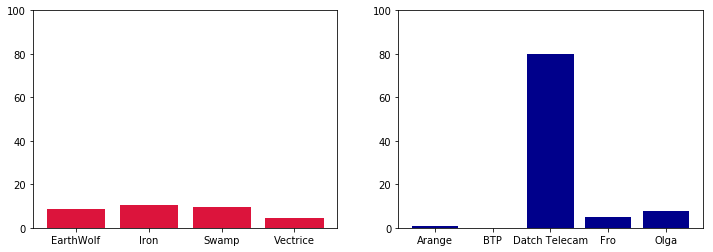

In [18]:
bar_not_connected(data, not_connected)

It is clear from the left barplot that the different internet service providers do not act the same way in the p2p. For instance, rougly 80% of the "Datch Telecam" users are not connected but are registered in the p2p. In contrast, only a neglectable number of users using "BTP" are registered but not connected. <br><br>
On the other hand, even if the variance is not the same, also browsers do not behave in the same way. Some browsers, more than others, allow users to be registered in the p2p and yet not connected.<br><br>
The fact that a user is not connected but is part of the p2p creates an issue that will be discussed in recommendation part.

In [19]:
def plot_p2p(dataset, width, sn):
    '''
    plots the p2p and cdn for a given stream on a given sliding window
    dataset : the preprocessed dataset
    width : the width of the window
    sn : the stream
    '''
    stream = dataset[dataset['#stream'] == sn]
    values_p2p = []
    values_cdn =[]
    number_of_batches = len(dataset) // width
    
    
    for i in range(number_of_batches):
        mean_p2p = np.mean(stream[i * width: (i+1) * width]['% p2p'])
        values_p2p.append(mean_p2p)
        values_cdn.append(100 - mean_p2p)
        
    values = [values_p2p, values_cdn]
    rng = np.arange(number_of_batches)
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.stackplot(rng, values, labels=['p2p','cdn'], colors=['sandybrown', 'dodgerblue'])
    ax.set_title('P2p and cdn over a window of {} for stream {}'.format(width, sn))
    ax.grid()
    ax.legend(loc='upper left')
    ax.set_ylabel('Percentage')
    ax.set_ylim(bottom = 0, top = 100)
    ax.axhline(50, color='k')
    
    
    fig.tight_layout()
    return fig, ax

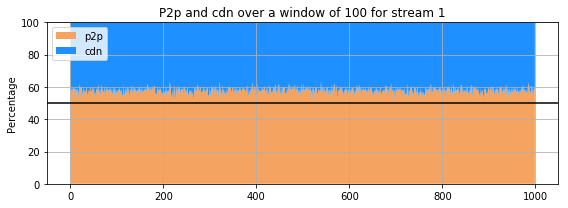

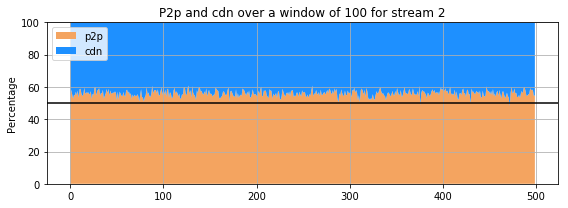

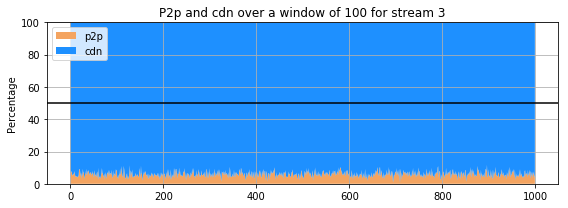

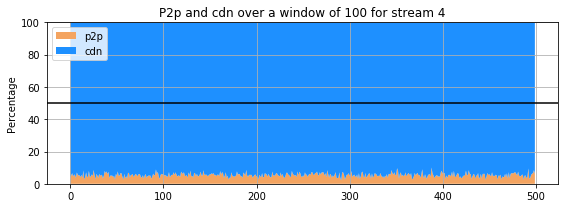

In [20]:
for st in range(1,5):
    plot_p2p(data_preprocessed, 100, st)

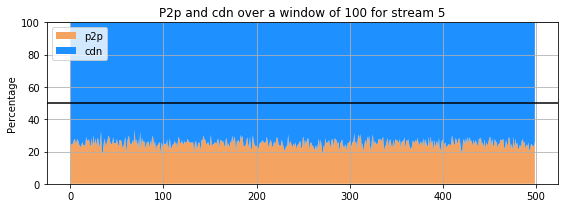

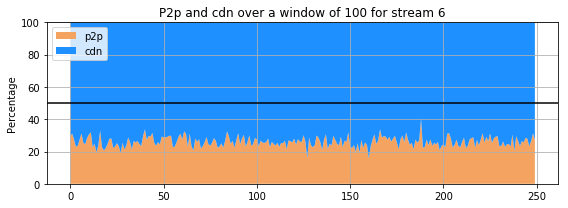

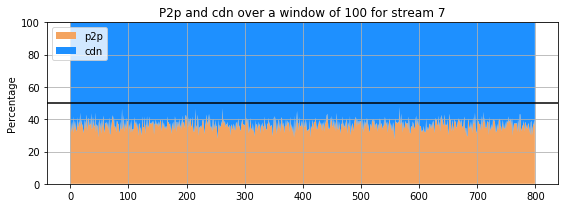

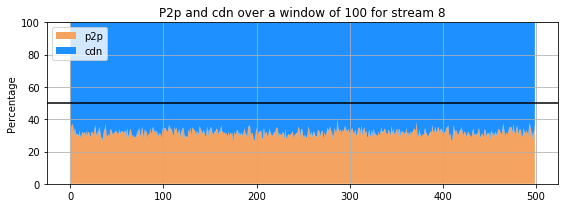

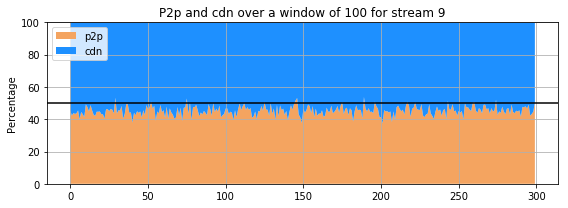

In [21]:
for st in range(5,10):
    plot_p2p(data_preprocessed, 100, st)

The previous 9 subplots, corresponding to the 9 streams present in the dataset, show that percentage of the amount of retrieval from p2p and cdn for each stream. The streams clearly do not behave the same way : for some, the proportion of retrieval from the p2p is comparable and even higher that the amount of retrieval from a cdn. However, for others (for instance stream 3 and 4), the retrieval of the stream from cdn is much more important than that of p2p. Only few users are sharing the stream in the p2p whereas all the others are getting it directly from the cdn. 

<a id='deux'></a>
## Recommendation for the service : 

The main goal of the streaming providors is to allow the users to watch high-quality videos without any buffering. The P2p architecture was designed to ensure this goal : all the users play the double role of servers and clients. In this scheme, a user can get the streaming from another user which is near him geographically. __This highly reduces the bandwidth cost__ of getting the stream directly from the cdn. However, there are many bottlenecks when using p2p. The exploratory data analysis that I did above shows some issues that need to be tackled in order to provide a better service. The two main issues seen are : <br><br>
     + Many users are registered in the dataset but actually not connected.
     + Many users are watching the same stream, but only few are being in a p2p where the majority is getting the video directly from cdn.
The first issue can be seen as an outlier detection problem : the users that are not connected are "bad" users in a sense that they create noise and disturb the p2p scheme. In fact, in a p2p scheme, some connected users may try to connect to those "not connected" users but will not retrieve anything from them. This is a loss of time and can be costly in term of bandwidth. Therefore, one obvious recommendation would be to detect them and discard them. Nevertheless, we may ask ourselves : how do these outliers emerge ? In fact, there could be many possible anserws. For example, as we saw from the plots, some Internet Service Providors can be bad and not really adapted to the p2p scheme since they register the users in the scheme while they are not actually connected. One can think of contacting these providors to find the actual source of this issue, or even try to adapt the p2p to those providors as well. Before getting to the second issue, I want to point that outlier detection would probably lead to false positive discovery. One ought to reduce the false positives in order not to loose the users <br><br>

The second issue concerns the users that are connected, watching the same video as others but not retrieving anything from p2p. Those kind of users naturally exist, since they can be the "first viewers" of the stream and thereof it is normal that there is no one they can retrieve the video from. Yet, when their number grow, this can be considered as an issue : they are not actually benefiting from the p2p. I am not sure, but I think this can be caused by the fact that the circumstances in which they are are not adapted for p2p : there are no other users geographically nearby, or maybe they somehow blocked the p2p retrieval for some reason. An other possible reason is that the stream they are watching is itself blocking a part of the p2p. So an idea can be to contact these stream providors and offer them a different javascript code to adapt with p2p. If the problem is geographical, we can may be think of installing a distrubted network in that area so that to facilicitate the retrieval of the stream.

This is the first time ever I had the chance to work on a streaming service. I think there are many assets and issues that can be tackled. If well dealt with, the experience of users would be better since he will have access to high quality and fast streaming with no buffering. This is really important since streaming is the new trend for watching videos. <br><br>
I believe that if I had more time, I could have done some other things with this data in order to emphasize on the cited bottlenecks. For example, I would formulate a machine learning problem of outlier detection. I would consider the p2p feature as a target feature and try to fit a function that estimates it from a training sample. Then, I would predict this target variable and see which users have a low / zero p2p retrieval value. These users would be considered as outliers and would be eliminated from the scheme. Then I would redo a plot of the percentage of data retrieval from p2p for the remaining users and see its effect. I think that this percentage will grow and therefor the users will benefit more from the p2p scheme. 